In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from systole.detection import ppg_peaks, interpolate_clipping, ecg_peaks
from systole.plots import plot_rr, plot_evoked
from systole import import_dataset1, import_ppg
from systole.utils import heart_rate, to_epochs, input_conversion
from systole.hrv import frequency_domain

from IPython.display import Image
from IPython.core.display import HTML

from bokeh.io import output_notebook
from bokeh.plotting import show
output_notebook()

sns.set_context('talk')

Loading BokehJS ...

During the recording, the participant had to rate the emotional valence of 36 neutral and 36 disgusting images (10 seconds max). Here, the stim channel encodes the presentation of disgusting (2) and neutral (1) images. The electrodermal activity was also recorded during this paradigm, but here we will only load the data of interest to save memory, then we only provide these arguments in the `modalities` parameter to speed up the download.

In [2]:
# Import ECg recording
ecg_df = import_dataset1(modalities=['ECG', 'Stim'])
signal, peaks = ecg_peaks(ecg_df.ecg, method='pan-tompkins', sfreq=1000, find_local=True)

## Instantaneous heart rate

In [3]:
show(
    plot_rr(peaks, input_type='peaks', backend='bokeh', figsize=400)
)

## Evoked heart rate

Finding R peaks and extract instantaneous heart rate.

In [4]:
signal, peaks = ecg_peaks(ecg_df.ecg, method='pan-tompkins', sfreq=1000, find_local=True)
heartrate, new_time = heart_rate(peaks, kind='previous', unit='bpm')

Create stim vectors for neutral and discusting images separately. Here, 1 encode the presentation of an image.

In [5]:
neutral, disgust = np.zeros(len(new_time)), np.zeros(len(new_time))

disgust[np.round(np.where(ecg_df.stim.to_numpy() == 2)[0]).astype(int)] = 1
neutral[np.round(np.where(ecg_df.stim.to_numpy() == 1)[0]).astype(int)] = 1

Event related plot.

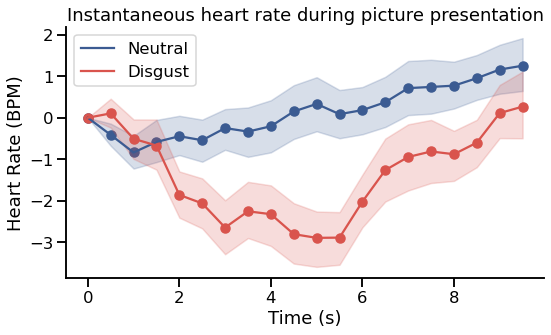

In [6]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8, 5))
for cond, data, col in zip(
        ['Neutral', 'Disgust'], [neutral, disgust],
        [sns.xkcd_rgb["denim blue"], sns.xkcd_rgb["pale red"]]):

    # Epoch intantaneous heart rate
    # and downsample to 2 Hz to save memory
    epochs = to_epochs(heartrate, data, tmin=0, tmax=10)[:, ::500]

    # Plot
    df = pd.DataFrame(epochs).melt()
    df.variable /= 2
    sns.lineplot(data=df, x='variable', y='value', ci=68, label=cond,
                 color=col, ax=ax, markers=['--', '-o'])

    plt.scatter(np.arange(0, 10, .5), epochs.mean(0), color=col)

#ax.set_xlim(0, 10)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Heart Rate (BPM)')
ax.set_title('Instantaneous heart rate during picture presentation')
sns.despine()
plt.tight_layout()